In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bob_ross = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-02-21/bob_ross.csv')

In [2]:
bob_ross.shape, bob_ross.columns[:15]

((403, 27),
 Index(['painting_index', 'img_src', 'painting_title', 'season', 'episode',
        'num_colors', 'youtube_src', 'colors', 'color_hex', 'Black_Gesso',
        'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna',
        'Indian_Red'],
       dtype='object'))

In [3]:
bob_ross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   painting_index    403 non-null    int64 
 1   img_src           403 non-null    object
 2   painting_title    403 non-null    object
 3   season            403 non-null    int64 
 4   episode           403 non-null    int64 
 5   num_colors        403 non-null    int64 
 6   youtube_src       403 non-null    object
 7   colors            403 non-null    object
 8   color_hex         403 non-null    object
 9   Black_Gesso       403 non-null    bool  
 10  Bright_Red        403 non-null    bool  
 11  Burnt_Umber       403 non-null    bool  
 12  Cadmium_Yellow    403 non-null    bool  
 13  Dark_Sienna       403 non-null    bool  
 14  Indian_Red        403 non-null    bool  
 15  Indian_Yellow     403 non-null    bool  
 16  Liquid_Black      403 non-null    bool  
 17  Liquid_Clear    

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.metrics import jaccard_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

df = bob_ross.copy()

color_cols = df.select_dtypes(include="bool").columns
X_bool = df[color_cols].astype(bool).to_numpy()

def phase_map(season):
    if season <= 10:
        return "Early"
    elif season <= 20:
        return "Middle"
    else:
        return "Late"

if "phase" not in df.columns:
    df["phase"] = df["season"].apply(phase_map)

In [6]:
from sklearn.decomposition import PCA

# Ensure color_cols and X_int are defined
# Assuming 'df' is available from previous cells.
color_cols = df.select_dtypes(include="bool").columns
X_int = df[color_cols].astype(int).values

# Centering (important!)
X = X_int
X_centered = X - X.mean(axis=0, keepdims=True);

n_components = 5
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_centered)

for i in range(n_components):
    df[f"PC{i+1}"] = X_pca[:, i]

# explained variance
evr = pca.explained_variance_ratio_
print("Explained variance ratio:")
for i, v in enumerate(evr, 1):
    print(f"PC{i}: {v:.3%}")

Explained variance ratio:
PC1: 23.181%
PC2: 18.630%
PC3: 10.783%
PC4: 8.385%
PC5: 7.949%


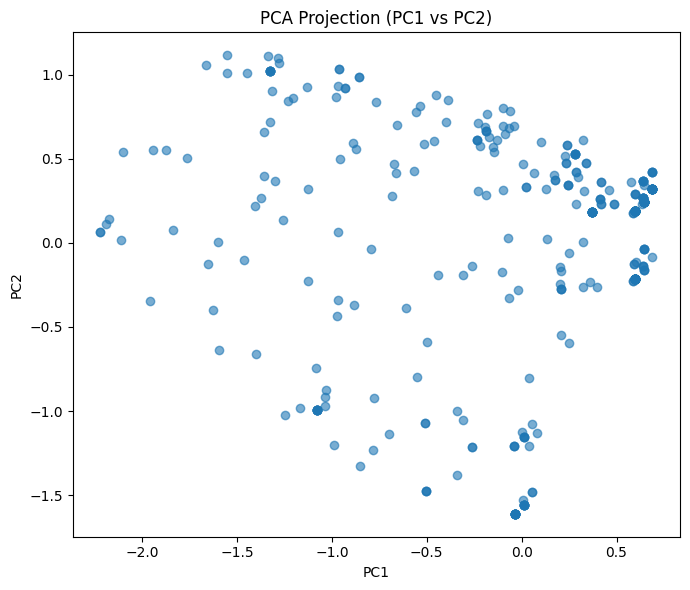

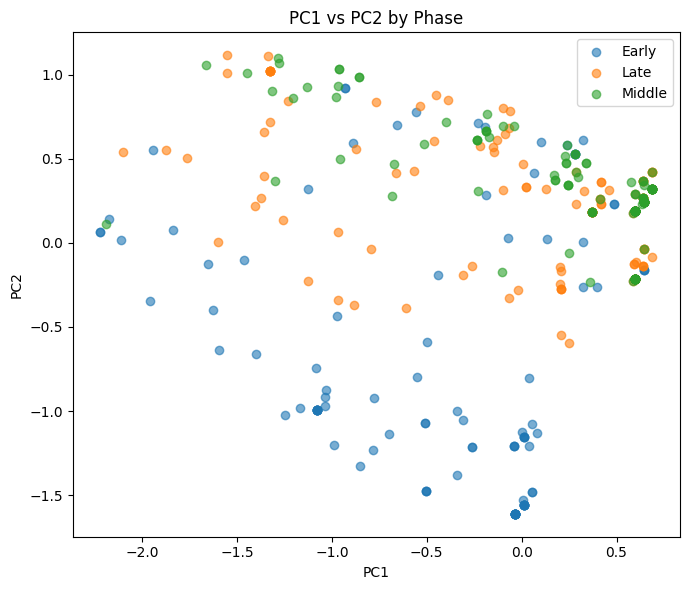

In [7]:
# Overall scattered points
plt.figure(figsize=(7,6))
plt.scatter(df["PC1"], df["PC2"], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection (PC1 vs PC2)")
plt.tight_layout()
plt.show()

# Color by phase (do not specify a specific color, let matplotlib default)
plt.figure(figsize=(7,6))
for ph, g in df.groupby("phase"):
    plt.scatter(g["PC1"], g["PC2"], alpha=0.6, label=ph)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 by Phase")
plt.legend()
plt.tight_layout()
plt.show()

          PC1    PC2
phase               
Early  -0.280 -0.569
Late    0.048  0.229
Middle  0.227  0.317


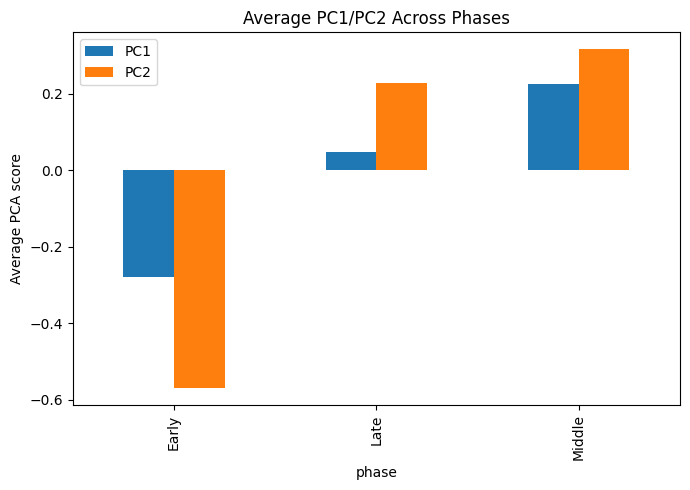

In [8]:
phase_pc = df.groupby("phase")[["PC1","PC2"]].mean().round(3)
print(phase_pc)

phase_pc.plot(kind="bar", figsize=(7,5))
plt.ylabel("Average PCA score")
plt.title("Average PC1/PC2 Across Phases")
plt.tight_layout()
plt.show()

In [9]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=color_cols,
    columns=[f"PC{i+1}" for i in range(n_components)]
)

print("Top positive contributors to PC1:")
print(loadings["PC1"].sort_values(ascending=False).head(10))
print("\nTop negative contributors to PC1:")
print(loadings["PC1"].sort_values().head(10))

print("\nTop positive contributors to PC2:")
print(loadings["PC2"].sort_values(ascending=False).head(10))
print("\nTop negative contributors to PC2:")
print(loadings["PC2"].sort_values().head(10))

Top positive contributors to PC1:
Indian_Yellow       0.468918
Yellow_Ochre        0.424173
Sap_Green           0.361173
Bright_Red          0.349065
Cadmium_Yellow      0.320750
Dark_Sienna         0.320724
Midnight_Black      0.235988
Phthalo_Blue        0.225262
Van_Dyke_Brown      0.116030
Alizarin_Crimson    0.108553
Name: PC1, dtype: float64

Top negative contributors to PC1:
Burnt_Umber        -0.076981
Prussian_Blue      -0.048117
Liquid_Black       -0.009593
Indian_Red         -0.000448
Phthalo_Green       0.001950
Liquid_Clear        0.002884
Titanium_White      0.018085
Black_Gesso         0.042461
Alizarin_Crimson    0.108553
Van_Dyke_Brown      0.116030
Name: PC1, dtype: float64

Top positive contributors to PC2:
Dark_Sienna         0.501053
Midnight_Black      0.491801
Liquid_Clear        0.102857
Black_Gesso         0.079183
Van_Dyke_Brown      0.010932
Phthalo_Blue        0.006870
Titanium_White      0.003102
Indian_Red          0.001780
Liquid_Black       -0.009934
Ali

In [10]:
k_recon = 2
pca_recon = PCA(n_components=k_recon, random_state=42)
Z = pca_recon.fit_transform(X_centered)

X_hat = pca_recon.inverse_transform(Z)
recon_rmse = np.sqrt(((X_centered - X_hat) ** 2).mean(axis=1))

df["recon_rmse"] = recon_rmse
print(df["recon_rmse"].describe())

count    403.000000
mean       0.261833
std        0.089127
min        0.123360
25%        0.200915
50%        0.256069
75%        0.315911
max        0.496231
Name: recon_rmse, dtype: float64


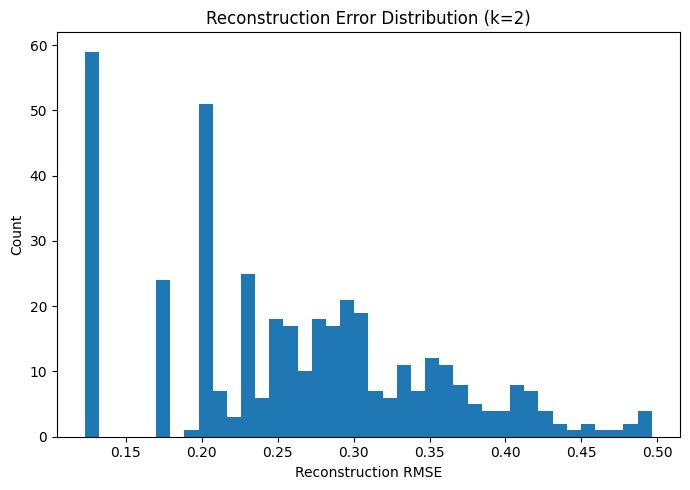

/tmp/ipython-input-849885365.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=["Early","Middle","Late"])


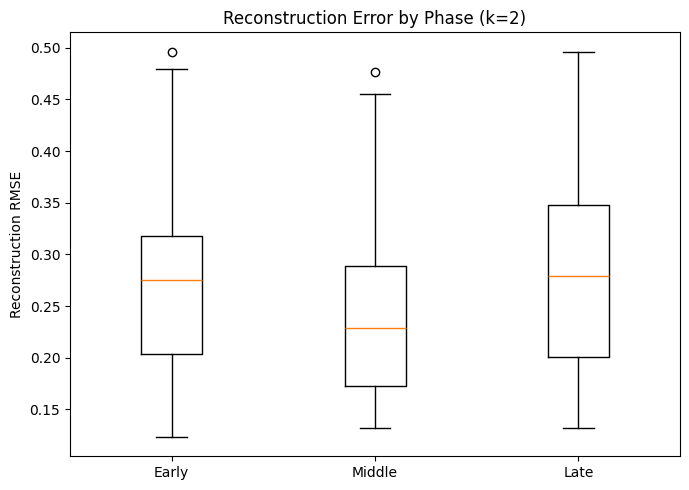

In [11]:
# distribution
plt.figure(figsize=(7,5))
plt.hist(df["recon_rmse"], bins=40)
plt.xlabel("Reconstruction RMSE")
plt.ylabel("Count")
plt.title(f"Reconstruction Error Distribution (k={k_recon})")
plt.tight_layout()
plt.show()

# phase boxplot
groups = [df.loc[df["phase"]==ph, "recon_rmse"].values for ph in ["Early","Middle","Late"]]
plt.figure(figsize=(7,5))
plt.boxplot(groups, labels=["Early","Middle","Late"])
plt.ylabel("Reconstruction RMSE")
plt.title(f"Reconstruction Error by Phase (k={k_recon})")
plt.tight_layout()
plt.show()

Anomaly rate: 0.052109181141439205
is_anomaly_recon     False     True 
phase                               
Early             0.946154  0.053846
Late              0.923077  0.076923
Middle            0.976923  0.023077


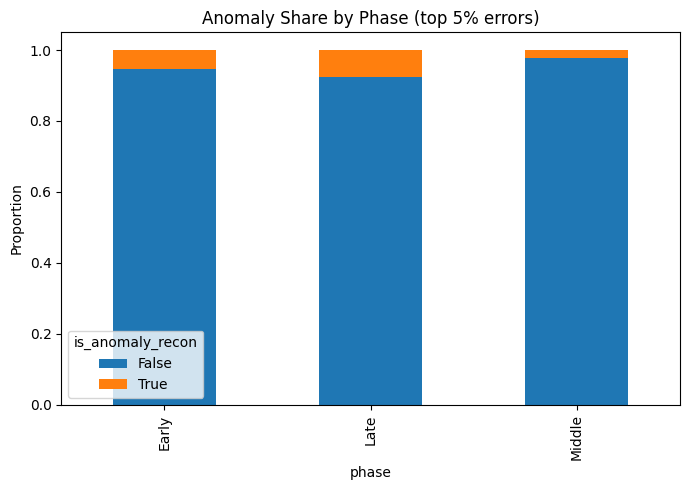

In [12]:
q = 0.95
thr = df["recon_rmse"].quantile(q)
df["is_anomaly_recon"] = df["recon_rmse"] >= thr

print("Anomaly rate:", df["is_anomaly_recon"].mean())

# The proportion of anomalies in phase
anom_phase = pd.crosstab(df["phase"], df["is_anomaly_recon"], normalize="index")
print(anom_phase)

anom_phase.plot(kind="bar", stacked=True, figsize=(7,5))
plt.title(f"Anomaly Share by Phase (top {int((1-q)*100)}% errors)")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()

In [13]:
# canonical palette: 0/1（>0.5）
canonical = (df[color_cols].astype(int).mean(axis=0) > 0.5).astype(int).values
X_int = df[color_cols].astype(int).values

# deviation = 1 - jaccard(row, canonical)
intersection = (X_int & canonical).sum(axis=1)
union = (X_int | canonical).sum(axis=1)
df["deviation_score"] = 1 - (intersection / np.clip(union, 1, None))

In [14]:
# pairwise jaccard distance matrix (NxN)
D = pairwise_distances(X_bool, metric="jaccard")

# linkage needs condensed distance vector
D_condensed = squareform(D, checks=False)

Z = linkage(D_condensed, method="average")  # average linkage on distance

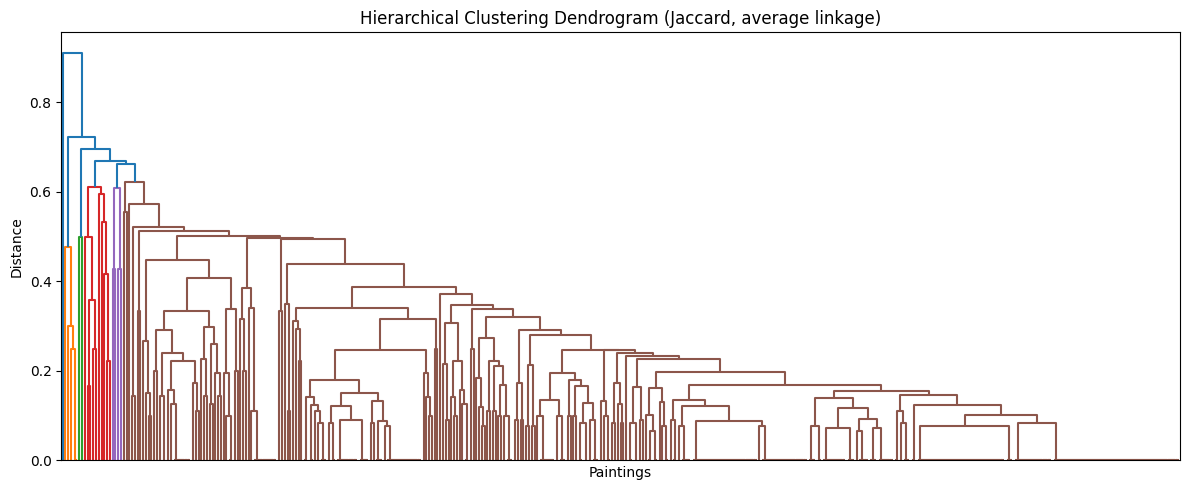

In [15]:
plt.figure(figsize=(12,5))
dendrogram(Z, no_labels=True)
plt.title("Hierarchical Clustering Dendrogram (Jaccard, average linkage)")
plt.xlabel("Paintings")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

The dendrogram does not exhibit sharply separated large branches, suggesting that palette variation forms a continuous structure rather than discrete, well-separated clusters. Most paintings merge at relatively low distances (below 0.3), indicating a strong shared palette core. A small subset of paintings only merges at higher distances (above 0.6), corresponding to stylistic outliers.

In [16]:
rows = []
for k in range(2, 9):
    labels = fcluster(Z, k, criterion="maxclust")

    # silhouette on precomputed distance
    sil = silhouette_score(D, labels, metric="precomputed")

    size_dist = pd.Series(labels).value_counts(normalize=True)
    largest = size_dist.max() * 100
    smallest = size_dist.min() * 100

    # deviation by cluster: range
    dev_means = df.groupby(labels)["deviation_score"].mean()
    dev_range = dev_means.max() - dev_means.min()

    rows.append({
        "k": k,
        "silhouette(precomputed)": round(sil, 3),
        "largest_cluster_%": round(largest, 1),
        "smallest_cluster_%": round(smallest, 1),
        "deviation_range(cluster_means)": round(dev_range, 3),
    })

summary = pd.DataFrame(rows).sort_values("silhouette(precomputed)", ascending=False)
summary

,k,silhouette(precomputed),largest_cluster_%,smallest_cluster_%,deviation_range(cluster_means)
0,2,0.598,99.8,0.2,0.683
1,3,0.498,98.5,0.2,0.689
2,4,0.471,98.0,0.2,0.691
3,5,0.467,95.5,0.2,0.702
4,6,0.455,94.5,0.2,0.706
5,7,0.431,94.0,0.2,0.709
6,8,0.424,94.0,0.2,0.709


In [17]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import numpy as np

df = bob_ross.copy()
color_cols = df.select_dtypes(include="bool").columns
X_bool = df[color_cols].astype(bool).to_numpy()

D = pairwise_distances(X_bool, metric="jaccard")
S = 1 - D   # convert distance to similarity

rows = []

for k in range(2, 9):
    spectral = SpectralClustering(
        n_clusters=k,
        affinity='precomputed',
        assign_labels='kmeans',
        random_state=42
    )

    labels = spectral.fit_predict(S)

    sil = silhouette_score(D, labels, metric="precomputed")

    size_dist = np.bincount(labels) / len(labels)
    largest = size_dist.max() * 100
    smallest = size_dist.min() * 100

    rows.append({
        "k": k,
        "silhouette": round(sil, 3),
        "largest_cluster_%": round(largest,1),
        "smallest_cluster_%": round(smallest,1)
    })

spectral_summary = pd.DataFrame(rows)
spectral_summary

,k,silhouette,largest_cluster_%,smallest_cluster_%
0,2,0.414,85.1,14.9
1,3,0.405,67.7,13.9
2,4,0.263,44.9,12.2
3,5,0.275,42.7,7.9
4,6,0.217,36.2,2.2
5,7,0.261,32.0,3.5
6,8,0.258,34.5,1.0


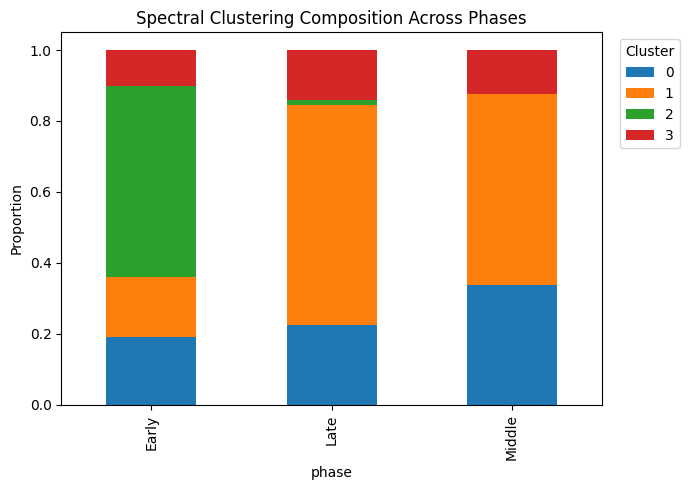

In [18]:
k = 4
spectral = SpectralClustering(
    n_clusters=k,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=42
)

# Re-add the 'phase' column to df, as it was re-initialized in a previous cell
def phase_map(season):
    if season <= 10:
        return "Early"
    elif season <= 20:
        return "Middle"
    else:
        return "Late"

if "phase" not in df.columns:
    df["phase"] = df["season"].apply(phase_map)

df["cluster_spectral"] = spectral.fit_predict(S)

# phase × cluster
phase_cluster = pd.crosstab(df["phase"], df["cluster_spectral"])
phase_cluster_pct = phase_cluster.div(phase_cluster.sum(axis=1), axis=0)

ax = phase_cluster_pct.plot(kind="bar", stacked=True, figsize=(7,5))
ax.set_ylabel("Proportion")
ax.set_title("Spectral Clustering Composition Across Phases")
plt.legend(title="Cluster", bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show()